## Transformer From Scratch

![Transformer Structure](png/tf.png)

根据论文中的transformer架构，我们可以把模型拆分为以下几个模块  
1. Encoder  
2. Decoder  
3. Positional-Encoding
    

而在Encoder和Decoder中，又分为以下几个小模块  
1. (Masked)Multihead-Attention  
2. Add & Norm  
3. Feed-Foward

至此，大致结构已经分析完成，接下来开始代码实现

首先，我们完成最基本的**多头注意力机制模块**(Multihead-Attention)

![多头注意力](png/mth.png)

每一个多头注意力模块都是由**h个注意力头**拼接而成，每一个注意力头的输入都是QKV三个矩阵  

In [77]:
import math
import torch
import torch.nn as nn

In [78]:
# 注意力头类
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None, e=1e-12):
        """
        k是[batch_size, head, length, d_k]的四维张量
        """
        batch_size, head, length, d_k = k.size()

        k_t = k.transpose(2, 3)
        score = (q @ k_t) / math.sqrt(d_k)

        if mask is not None:
            score = score.masked_fill(mask == 0, -10000)

        score = self.softmax(score)

        v = score @ v

        return v, score
    
# 多头注意力类
class MultiheadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiheadAttention, self).__init__()
        '''
        n_heads: 注意力头数
        d_model: 模型维度(通常为512)
        '''
        self.n_heads = n_heads
        self.attention = ScaledDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        #1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        #2. split tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        #3. do scale dot product to compute similarity
        if mask is not None:
            # 假设 mask 是 [B, L_q, L_k]
            # 需要扩展到 [B, H, L_q, L_k]
            mask = mask.unsqueeze(1)  # 或者使用 expand

        out, attention = self.attention(q, k, v, mask=mask)

        #4. concat and pass linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        return out

    # 将输入的QKV根据注意力头数进行划分
    def split(self, tensor):
        batch_size, length, d_model = tensor.size()
        d_tensor = d_model // self.n_heads
        tensor = tensor.view(batch_size, length, self.n_heads, d_tensor).transpose(1, 2)

        return tensor

    # 最后将各个头的输出进行拼接
    def concat(self, tensor):
        batch_size, head, length, d_tensor = tensor.size()

        d_model = d_tensor * head

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)

        return tensor  

In [79]:
mul = MultiheadAttention(512, 6)
print(mul)

MultiheadAttention(
  (attention): ScaledDotProductAttention(
    (softmax): Softmax(dim=-1)
  )
  (w_q): Linear(in_features=512, out_features=512, bias=True)
  (w_k): Linear(in_features=512, out_features=512, bias=True)
  (w_v): Linear(in_features=512, out_features=512, bias=True)
  (w_concat): Linear(in_features=512, out_features=512, bias=True)
)


接下来，完成功能部件**位置编码**

![pe](png/pe.png)

根据公式，我们来代码实现

In [80]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, device=None):
        '''
        参数d_model: 模型维度
        参数max_len: 最大序列长度
        参数device: 设备
        '''
        super(PositionalEncoding, self).__init__()

        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        #从一维张量到二维，方便后续运算进行广播操作，变成[max_len, d_model/2]的矩阵

        _2i = torch.arange(0, d_model, step=2, device=device).float()

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))

    def forward(self, x):
        '''
        参数x: [batch_size, seq_len, d_model]的张量
        '''
        seq_len = x.size(1)
        pos_enc = self.encoding[:seq_len, :].unsqueeze(0)
        return x + pos_enc

接下来实现**FFN**

In [81]:
class PositionWiseFFN(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionWiseFFN, self).__init__()
        '''
        d_model: 模型维度
        d_ff: FFN中间层维度(一般为2048)
        '''
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

最后，完成**Layernorm**层

In [82]:
class AddNorm(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super(AddNorm, self).__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer_output):
        '''
        x: 原始输入
        sublayer_output: 子层输出
        '''
        return self.norm(x + self.dropout(sublayer_output))

至此，我们就可以完成Transformer整体模型的构建了

In [83]:
# Decoder模块类构建
class DecoderBlock(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, dropout=0.1):
        super().__init__()
        self.self_atten = MultiheadAttention(d_model, n_heads)
        self.enc_dec_atten = MultiheadAttention(d_model, n_heads)
        self.norm1 = AddNorm(d_model, dropout)
        self.norm2 = AddNorm(d_model, dropout)
        self.norm3 = AddNorm(d_model, dropout)
        self.FFN = PositionWiseFFN(d_model, d_ff, dropout)

    def forward(self, x, enc_output, tgt_mask=None, memory_mask=None):
        x = self.norm1(x, self.self_atten(x, x, x, tgt_mask))
        x = self.norm2(x, self.enc_dec_atten(x, enc_output, enc_output, memory_mask))
        x = self.norm3(x, self.FFN(x))
        return x

class Decoder(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, voc_size, num_layers, max_len, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(voc_size, d_model)
        self.linear = nn.Linear(d_model, voc_size)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout)
        self.layers = nn.ModuleList([
            DecoderBlock(d_model, d_ff, n_heads, dropout) for _ in range(num_layers)
        ])

    def forward(self, enc_output, tgt_seq, tgt_mask=None, memory_mask=None):
        x = self.embedding(tgt_seq)
        x = self.pos_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_output, tgt_mask, memory_mask)
        x = self.linear(x)
        return x

# Encoder模块类构建
class EncoderBlock(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, dropout=0.1):
        super(EncoderBlock, self).__init__()
        self.attention = MultiheadAttention(d_model, n_heads)
        self.norm1 = AddNorm(d_model, dropout)
        self.FFN = PositionWiseFFN(d_model, d_ff, dropout)
        self.norm2 = AddNorm(d_model, dropout)

    def forward(self, x, mask=None):
        x = self.norm1(x, self.attention(x, x, x, mask))
        x = self.norm2(x, self.FFN(x))
        return x
    
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, d_ff, n_heads, voc_size, max_len):
        super().__init__()
        self.embedding = nn.Embedding(voc_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, device='cuda', max_len=max_len)
        self.layers = nn.ModuleList([
            EncoderBlock(d_model, d_ff, n_heads) for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

In [84]:
class Transformer(nn.Module):
    def __init__(self, src_voc_size, tgt_voc_size, d_model=512, n_layers=6, n_heads=8, d_ff=2048, max_len=512, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=n_layers, d_model=d_model, d_ff=d_ff, n_heads=n_heads, voc_size=src_voc_size, max_len=max_len)
        self.decoder = Decoder(num_layers=n_layers, d_model=d_model, d_ff=d_ff, n_heads=n_heads, voc_size=tgt_voc_size, max_len=max_len, dropout=dropout)

    def forward(self, src_seq, tgt_seq, src_mask=None, tgt_mask=None, memory_mask=None):
        enc_output = self.encoder(src_seq, src_mask)
        output = self.decoder(tgt_seq, enc_output, tgt_mask, memory_mask)
        return output   

完整代码如下

In [85]:
# 注意力头类
def masked_fill_inf(x, mask):
    # mask: True = valid, False = masked
    x = x.masked_fill(~mask, float('-inf'))
    return x

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None, e=1e-12):
        """
        k是[batch_size, head, length, d_k]的四维张量
        """
        batch_size, head, length, d_k = k.size()

        k_t = k.transpose(2, 3)
        score = torch.matmul(q, k_t) / math.sqrt(d_k)

        if mask is not None:
            score = masked_fill_inf(score, mask)

        score = self.softmax(score)

        v = torch.matmul(score, v)

        return v, score
    
# 多头注意力类
class MultiheadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiheadAttention, self).__init__()
        '''
        n_heads: 注意力头数
        d_model: 模型维度(通常为512)
        '''
        self.n_heads = n_heads
        self.attention = ScaledDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        #1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        #2. split tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        #3. do scale dot product to compute similarity

        out, attention = self.attention(q, k, v, mask=mask)

        #4. concat and pass linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        return out

    # 将输入的QKV根据注意力头数进行划分
    def split(self, tensor):
        batch_size, length, d_model = tensor.size()
        d_tensor = d_model // self.n_heads
        tensor = tensor.view(batch_size, length, self.n_heads, d_tensor).transpose(1, 2)

        return tensor

    # 最后将各个头的输出进行拼接
    def concat(self, tensor):
        #print(tensor.size())
        batch_size, head, length, d_tensor = tensor.size()

        d_model = d_tensor * head

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)

        return tensor
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, device=None):
        '''
        参数d_model: 模型维度
        参数max_len: 最大序列长度
        参数device: 设备
        '''
        super(PositionalEncoding, self).__init__()

        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        #从一维张量到二维，方便后续运算进行广播操作，变成[max_len, d_model/2]的矩阵

        _2i = torch.arange(0, d_model, step=2, device=device).float()

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))

    def forward(self, x):
        '''
        参数x: [batch_size, seq_len, d_model]的张量
        '''
        seq_len = x.size(1)
        pos_enc = self.encoding[:seq_len, :].unsqueeze(0)
        return x + pos_enc
    
class PositionWiseFFN(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionWiseFFN, self).__init__()
        '''
        d_model: 模型维度
        d_ff: FFN中间层维度(一般为2048)
        '''
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x
    
class AddNorm(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super(AddNorm, self).__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer_output):
        '''
        x: 原始输入
        sublayer_output: 子层输出
        '''
        return self.norm(x + self.dropout(sublayer_output))
    
# Decoder模块类构建
class DecoderBlock(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, dropout=0.1):
        super().__init__()
        self.self_atten = MultiheadAttention(d_model, n_heads)
        self.enc_dec_atten = MultiheadAttention(d_model, n_heads)
        self.norm1 = AddNorm(d_model, dropout)
        self.norm2 = AddNorm(d_model, dropout)
        self.norm3 = AddNorm(d_model, dropout)
        self.FFN = PositionWiseFFN(d_model, d_ff, dropout)

    def forward(self, x, enc_output, tgt_mask=None, memory_mask=None):
        x = self.norm1(x, self.self_atten(x, x, x, tgt_mask))
        x = self.norm2(x, self.enc_dec_atten(x, enc_output, enc_output, memory_mask))
        x = self.norm3(x, self.FFN(x))
        return x

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, d_ff, n_heads, voc_size, max_len):
        super().__init__()
        self.embedding = nn.Embedding(voc_size, d_model)
        self.linear = nn.Linear(d_model, voc_size)
        self.pos_encoding = PositionalEncoding(d_model, device='cuda', max_len=max_len)
        self.layers = nn.ModuleList([
            DecoderBlock(d_model, d_ff, n_heads) for _ in range(num_layers)
        ])

    def forward(self, enc_output, tgt_seq, tgt_mask=None, memory_mask=None):
        x = self.embedding(tgt_seq)
        x = self.pos_encoding(x)
        for layer in self.layers:
            x = layer(x, enc_output, tgt_mask, memory_mask)
        x = self.linear(x)
        return x

# Encoder模块类构建
class EncoderBlock(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, dropout=0.1):
        super(EncoderBlock, self).__init__()
        self.attention = MultiheadAttention(d_model, n_heads)
        self.norm1 = AddNorm(d_model, dropout)
        self.FFN = PositionWiseFFN(d_model, d_ff, dropout)
        self.norm2 = AddNorm(d_model, dropout)

    def forward(self, x, mask=None):
        x = self.norm1(x, self.attention(x, x, x, mask))
        x = self.norm2(x, self.FFN(x))
        return x
    
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, d_ff, n_heads, voc_size, max_len):
        super().__init__()
        self.embedding = nn.Embedding(voc_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, device='cuda', max_len=max_len)
        self.layers = nn.ModuleList([
            EncoderBlock(d_model, d_ff, n_heads) for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x
    
class Transformer(nn.Module):
    def __init__(self, src_voc_size, tgt_voc_size, d_model=512, n_layers=6, n_heads=8, d_ff=2048, max_len=512, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=n_layers, d_model=d_model, d_ff=d_ff, n_heads=n_heads, voc_size=src_voc_size, max_len=max_len)
        self.decoder = Decoder(num_layers=n_layers, d_model=d_model, d_ff=d_ff, n_heads=n_heads, voc_size=tgt_voc_size, max_len=max_len)

    def forward(self, src_seq, tgt_seq, src_mask=None, tgt_mask=None, memory_mask=None):
        enc_output = self.encoder(src_seq, src_mask)
        output = self.decoder(tgt_seq, enc_output, tgt_mask, memory_mask)
        return output 

In [86]:
tf = Transformer(10, 10)
print(tf)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(10, 512)
    (pos_encoding): PositionalEncoding()
    (layers): ModuleList(
      (0-5): 6 x EncoderBlock(
        (attention): MultiheadAttention(
          (attention): ScaledDotProductAttention(
            (softmax): Softmax(dim=-1)
          )
          (w_q): Linear(in_features=512, out_features=512, bias=True)
          (w_k): Linear(in_features=512, out_features=512, bias=True)
          (w_v): Linear(in_features=512, out_features=512, bias=True)
          (w_concat): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): AddNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (FFN): PositionWiseFFN(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
          (dropout): Dropout

接下来我们开始训练已经写好的Transformer模型吧  
  
我准备使用Multi30k数据集进行训练

下载spacy所需的模型

In [87]:
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/14.6 MB ? eta -:--:--
     - -------------------------------------- 0.5/14.6 MB 8.2 MB/s eta 0:00:02
     ------------------- -------------------- 7.1/14.6 MB 29.0 MB/s eta 0:00:01
     -------------------- ------------------- 7.6/14.6 MB 26.0 MB/s eta 0:00:01
     --------------------- ------------------ 7.9/14.6 MB 13.2 MB/s eta 0:00:01
     --------------------------------- ----- 12.6/14.6 MB 14.6 MB/s eta 0:00:01
     --------------------------------------- 14.6/14.6 MB 13.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 8.5 MB/s eta 0:00:02
     ---------------------- ----------------- 7.3/12.8 MB 26.6 MB/s eta 0:

In [89]:
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import spacy

'''
    Multi30k的数据集样本格式为:
        (en, de)
    的元组
'''
ds = load_dataset("bentrevett/multi30k")
#print(ds)

spacy_de = spacy.load("de_core_news_sm")
spacy_en = spacy.load("en_core_web_sm")

def tokenize_en(text):
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

def tokenize_de(text):
    return [tok.text.lower() for tok in spacy_de.tokenizer(text)]


# ------ 构建词表 ------
def build_vocab(texts, tokenizer, min_freq=2):
    counter = Counter()
    for text in texts:
        tokens = tokenizer(text)
        counter.update(tokens)
    vocab = {"<pad>": 0, "<unk>": 1, "<bos>": 2, "<eos>": 3}
    for word, freq in counter.items():
        if freq >= min_freq and word not in vocab:
            vocab[word] = len(vocab)
    return vocab

# ------ 数字化文本 ------
def numericalize(tokens, vocab, bos=True, eos=True):
    ids = [vocab.get(tok, vocab["<unk>"]) for tok in tokens]
    if bos: ids = [vocab["<bos>"]] + ids
    if eos: ids = ids + [vocab["<eos>"]]
    return ids

# ------ Padding ------
def pad_sequence(sequences, pad_idx):
    max_len = max(len(seq) for seq in sequences)
    return [seq + [pad_idx] * (max_len - len(seq)) for seq in sequences]

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    pad_idx_src = de_vocab["<pad>"]
    pad_idx_tgt = en_vocab["<pad>"]

    src_batch = pad_sequence(src_batch, pad_idx_src)
    tgt_batch = pad_sequence(tgt_batch, pad_idx_tgt)

    src_batch = torch.tensor(src_batch, dtype=torch.long)
    tgt_batch = torch.tensor(tgt_batch, dtype=torch.long)

    return src_batch, tgt_batch

class TranslationDataset(Dataset):
    def __init__(self, src_texts, tgt_texts, src_vocab, tgt_vocab):
        self.src_data = [numericalize(tokenize_de(s), src_vocab) for s in src_texts]
        self.tgt_data = [numericalize(tokenize_en(t), tgt_vocab) for t in tgt_texts]

    def __len__(self):
        return len(self.src_data)

    def __getitem__(self, idx):
        return self.src_data[idx], self.tgt_data[idx]
    
de_texts = [example['de'] for example in ds['train']]
en_texts = [example['en'] for example in ds['train']]

de_vocab = build_vocab(de_texts, tokenize_de)
en_vocab = build_vocab(en_texts, tokenize_en)
    
train_dataset = TranslationDataset(de_texts, en_texts, de_vocab, en_vocab)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)

de_texts_val = [example['de'] for example in ds['validation']]
en_texts_val = [example['en'] for example in ds['validation']]

val_dataset = TranslationDataset(de_texts_val, en_texts_val, de_vocab, en_vocab)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)



以上完成数据加载阶段，接下来开始训练

In [ ]:
from tqdm import tqdm
# ------ 创建Mask -------

def create_padding_mask(seq, pad_idx):
    # seq_shape: (batch_size, seq_len)
    # return_size: (batch_size, 1, 1, seq_len)
    return (seq != pad_idx).unsqueeze(1).unsqueeze(2)

def create_subsequent_mask(size):
    mask = torch.tril(torch.ones((size, size), dtype=torch.bool))
    return mask

# ------ 训练 ------

model = Transformer(len(de_vocab), len(en_vocab))
criterion = nn.CrossEntropyLoss(ignore_index=en_vocab["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


def train_model(num_epochs, device, train_loader, val_loader=None):
    model.to(device)
    best_loss = float('inf')  # 初始最佳损失
    best_model_path = "best_model.pth"

    for epoch in range(num_epochs):
        model.train()
        progress = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        total_loss = 0

        for src_batch, tgt_batch in progress:
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            src_mask = create_padding_mask(src_batch, pad_idx=de_vocab["<pad>"])
            memory_mask = create_padding_mask(src_batch, pad_idx=de_vocab["<pad>"])

            tgt_input = tgt_batch[:, :-1]
            tgt_output = tgt_batch[:, 1:]
            batch_size, tgt_len = tgt_input.size()

            tgt_pad_mask = create_padding_mask(tgt_input, pad_idx=en_vocab["<pad>"])
            tgt_sub_mask = create_subsequent_mask(tgt_len).to(tgt_input.device)
            tgt_sub_mask = tgt_sub_mask.unsqueeze(0).unsqueeze(1)
            tgt_mask = tgt_pad_mask & tgt_sub_mask

            enc_output = model.encoder(src_batch, src_mask)
            logits = model.decoder(enc_output, tgt_input, tgt_mask=tgt_mask, memory_mask=memory_mask)

            loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            total_loss += loss.item()
            progress.set_postfix(loss=loss.item())

        print(f"Epoch {epoch + 1} Training Loss: {total_loss / len(train_loader):.4f}")

        # ============ 验证逻辑 ============
        if val_loader is not None:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for src_val, tgt_val in val_loader:
                    src_val = src_val.to(device)
                    tgt_val = tgt_val.to(device)

                    src_mask = create_padding_mask(src_val, pad_idx=de_vocab["<pad>"])
                    memory_mask = create_padding_mask(src_val, pad_idx=de_vocab["<pad>"])

                    tgt_input = tgt_val[:, :-1]
                    tgt_output = tgt_val[:, 1:]
                    tgt_len = tgt_input.size(1)

                    tgt_pad_mask = create_padding_mask(tgt_input, pad_idx=en_vocab["<pad>"])
                    tgt_sub_mask = create_subsequent_mask(tgt_len).to(tgt_input.device)
                    tgt_sub_mask = tgt_sub_mask.unsqueeze(0).unsqueeze(1)
                    tgt_mask = tgt_pad_mask & tgt_sub_mask

                    enc_output = model.encoder(src_val, src_mask)
                    logits = model.decoder(enc_output, tgt_input, tgt_mask=tgt_mask, memory_mask=memory_mask)

                    loss = criterion(logits.reshape(-1, logits.size(-1)), tgt_output.reshape(-1))
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            print(f"Epoch {epoch + 1} Validation Loss: {val_loss:.4f}")

            # ==== 保存最佳模型 ====
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"✅ Best model saved at epoch {epoch + 1}, val_loss = {val_loss:.4f}")

    # 训练结束后保存最终模型（不一定是最优）
    torch.save(model.state_dict(), "last_model.pth")
    print("✅ Final model saved as last_model.pth")

train_model(25, device, train_loader, val_loader)



cuda


Epoch 1/25: 100%|██████████| 907/907 [02:41<00:00,  5.62it/s, loss=3.16]


Epoch 1 Training Loss: 3.4299
Epoch 1 Validation Loss: 2.4953
✅ Best model saved at epoch 1, val_loss = 2.4953


Epoch 2/25: 100%|██████████| 907/907 [04:00<00:00,  3.77it/s, loss=1.83]


Epoch 2 Training Loss: 2.3018
Epoch 2 Validation Loss: 2.0408
✅ Best model saved at epoch 2, val_loss = 2.0408


Epoch 3/25: 100%|██████████| 907/907 [03:34<00:00,  4.22it/s, loss=1.98]


Epoch 3 Training Loss: 1.8557
Epoch 3 Validation Loss: 1.8169
✅ Best model saved at epoch 3, val_loss = 1.8169


Epoch 4/25: 100%|██████████| 907/907 [03:45<00:00,  4.03it/s, loss=0.855]


Epoch 4 Training Loss: 1.5334
Epoch 4 Validation Loss: 1.7535
✅ Best model saved at epoch 4, val_loss = 1.7535


Epoch 5/25: 100%|██████████| 907/907 [03:41<00:00,  4.09it/s, loss=1.16] 


Epoch 5 Training Loss: 1.2653
Epoch 5 Validation Loss: 1.6720
✅ Best model saved at epoch 5, val_loss = 1.6720


Epoch 6/25: 100%|██████████| 907/907 [03:42<00:00,  4.09it/s, loss=0.693]


Epoch 6 Training Loss: 1.0277
Epoch 6 Validation Loss: 1.6819


Epoch 7/25: 100%|██████████| 907/907 [03:35<00:00,  4.22it/s, loss=0.939]


Epoch 7 Training Loss: 0.8169
Epoch 7 Validation Loss: 1.7065


Epoch 8/25: 100%|██████████| 907/907 [03:41<00:00,  4.09it/s, loss=1.05] 


Epoch 8 Training Loss: 0.6326
Epoch 8 Validation Loss: 1.7926


Epoch 9/25: 100%|██████████| 907/907 [03:53<00:00,  3.88it/s, loss=0.397]


Epoch 9 Training Loss: 0.4749
Epoch 9 Validation Loss: 1.8723


Epoch 10/25: 100%|██████████| 907/907 [03:54<00:00,  3.87it/s, loss=0.391]


Epoch 10 Training Loss: 0.3517
Epoch 10 Validation Loss: 1.9441


Epoch 11/25: 100%|██████████| 907/907 [03:52<00:00,  3.89it/s, loss=0.334]


Epoch 11 Training Loss: 0.2609
Epoch 11 Validation Loss: 2.0464


Epoch 12/25: 100%|██████████| 907/907 [03:54<00:00,  3.87it/s, loss=0.325]


Epoch 12 Training Loss: 0.2062
Epoch 12 Validation Loss: 2.0938


Epoch 13/25: 100%|██████████| 907/907 [03:55<00:00,  3.84it/s, loss=0.142] 


Epoch 13 Training Loss: 0.1695
Epoch 13 Validation Loss: 2.1754


Epoch 14/25: 100%|██████████| 907/907 [04:04<00:00,  3.71it/s, loss=0.146] 


Epoch 14 Training Loss: 0.1405
Epoch 14 Validation Loss: 2.2541


Epoch 15/25: 100%|██████████| 907/907 [04:08<00:00,  3.64it/s, loss=0.136] 


Epoch 15 Training Loss: 0.1248
Epoch 15 Validation Loss: 2.2783


Epoch 16/25: 100%|██████████| 907/907 [03:58<00:00,  3.80it/s, loss=0.14]  


Epoch 16 Training Loss: 0.1119
Epoch 16 Validation Loss: 2.3570


Epoch 17/25: 100%|██████████| 907/907 [03:48<00:00,  3.97it/s, loss=0.136] 


Epoch 17 Training Loss: 0.0994
Epoch 17 Validation Loss: 2.3657


Epoch 18/25: 100%|██████████| 907/907 [03:58<00:00,  3.80it/s, loss=0.0876]


Epoch 18 Training Loss: 0.0929
Epoch 18 Validation Loss: 2.4299


Epoch 19/25: 100%|██████████| 907/907 [03:51<00:00,  3.91it/s, loss=0.11]  


Epoch 19 Training Loss: 0.0870
Epoch 19 Validation Loss: 2.4833


Epoch 20/25: 100%|██████████| 907/907 [03:51<00:00,  3.91it/s, loss=0.127] 


Epoch 20 Training Loss: 0.0794
Epoch 20 Validation Loss: 2.5041


Epoch 21/25: 100%|██████████| 907/907 [03:53<00:00,  3.89it/s, loss=0.116] 


Epoch 21 Training Loss: 0.0755
Epoch 21 Validation Loss: 2.5228


Epoch 22/25: 100%|██████████| 907/907 [04:07<00:00,  3.67it/s, loss=0.0518]


Epoch 22 Training Loss: 0.0734
Epoch 22 Validation Loss: 2.5663


Epoch 23/25: 100%|██████████| 907/907 [03:59<00:00,  3.78it/s, loss=0.134] 


Epoch 23 Training Loss: 0.0696
Epoch 23 Validation Loss: 2.6214


Epoch 24/25: 100%|██████████| 907/907 [04:00<00:00,  3.77it/s, loss=0.0694]


Epoch 24 Training Loss: 0.0665
Epoch 24 Validation Loss: 2.6588


Epoch 25/25: 100%|██████████| 907/907 [03:47<00:00,  3.99it/s, loss=0.0393]


Epoch 25 Training Loss: 0.0633
Epoch 25 Validation Loss: 2.6827
✅ Final model saved as last_model.pth


训练已完成，接下来我们进行评估

In [ ]:
de_test_texts = [example['de'] for example in ds['test']]
en_test_texts = [example['en'] for example in ds['test']]
test_dataset = TranslationDataset(de_test_texts, en_test_texts, de_vocab, en_vocab)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
smoothie = SmoothingFunction().method4

def idx2word(vocab, idx):
    idx2word_map = {v: k for k, v in vocab.items()}
    return idx2word_map.get(idx, "<unk>")

# 贪婪解码器：逐步生成目标序列
def greedy_decode(model, src, src_mask, max_len, start_symbol, pad_idx):
    memory = model.encoder(src, src_mask)
    ys = torch.ones(src.size(0), 1).fill_(start_symbol).type_as(src)  # 初始 <bos>

    for _ in range(max_len - 1):
        tgt_mask = create_subsequent_mask(ys.size(1)).to(src.device)  # 自回归mask
        tgt_mask = tgt_mask.unsqueeze(0).unsqueeze(1)  # (1, 1, tgt_len, tgt_len)
        tgt_pad_mask = create_padding_mask(ys, pad_idx=pad_idx)
        full_tgt_mask = tgt_mask & tgt_pad_mask

        out = model.decoder(memory, ys, tgt_mask=full_tgt_mask, memory_mask=src_mask)
        next_token = out[:, -1, :].argmax(dim=-1, keepdim=True)
        ys = torch.cat([ys, next_token], dim=1)

    return ys


# 模型评估（自动生成 + 计算 BLEU）
def evaluate(model, data_loader, device, max_len=50, verbose=False, load_model_path=None):
    if load_model_path:
        model.load_state_dict(torch.load(load_model_path))
        print(f"✅ Model loaded from {load_model_path}")

    model.eval()
    references = []
    hypotheses = []

    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for batch_idx, (src_batch, tgt_batch) in enumerate(data_loader):
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            src_mask = create_padding_mask(src_batch, pad_idx=de_vocab["<pad>"])
            memory_mask = src_mask.clone()

            tgt_input = tgt_batch[:, :-1]
            tgt_output = tgt_batch[:, 1:]

            tgt_pad_mask = create_padding_mask(tgt_input, pad_idx=en_vocab["<pad>"])
            tgt_sub_mask = create_subsequent_mask(tgt_input.size(1)).to(device).unsqueeze(0).unsqueeze(1)
            tgt_mask = tgt_pad_mask & tgt_sub_mask

            output = model.decoder(
                model.encoder(src_batch, src_mask),
                tgt_input,
                tgt_mask=tgt_mask,
                memory_mask=memory_mask
            )

            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
            total_loss += loss.item()
            num_batches += 1

            # 生成翻译
            pred_seqs = greedy_decode(
                model, src_batch, src_mask,
                max_len=max_len,
                start_symbol=en_vocab["<bos>"],
                pad_idx=en_vocab["<pad>"]
            )

            for i, (pred, truth) in enumerate(zip(pred_seqs, tgt_batch)):
                pred_tokens = [
                    idx2word(en_vocab, idx.item())
                    for idx in pred
                    if idx.item() not in [en_vocab["<pad>"], en_vocab["<bos>"], en_vocab["<eos>"]]
                ]
                truth_tokens = [
                    idx2word(en_vocab, idx.item())
                    for idx in truth
                    if idx.item() not in [en_vocab["<pad>"], en_vocab["<bos>"], en_vocab["<eos>"]]
                ]

                hypotheses.append(pred_tokens)
                references.append([truth_tokens])

                if verbose and batch_idx == 0 and i < 3:
                    print(f"\n👉 Source {i + 1}:")
                    print(f"Predicted: {' '.join(pred_tokens)}")
                    print(f"Reference: {' '.join(truth_tokens)}")

    avg_loss = total_loss / num_batches
    bleu = corpus_bleu(references, hypotheses, smoothing_function=smoothie) * 100

    return avg_loss, bleu





In [ ]:
test_loss, test_bleu = evaluate(model, test_loader, device, verbose=True, load_model_path="last_model.pth")
print(f"\n📊 Test Loss: {test_loss:.4f}")
print(f"🔍 BLEU Score: {test_bleu:.2f}")

✅ Model loaded from last_model.pth

👉 Source 1:
Predicted: a man in an orange hat looking at something . . . . . . . . . . . . . . . . . . up . .
Reference: a man in an orange hat starring at something .

👉 Source 2:
Predicted: a boston runs across grass in front of a white fence . . . . . . . . . . . . . . . on . on . on .
Reference: a boston terrier is running on lush green grass in front of a white fence .

👉 Source 3:
Predicted: a girl is in a karate uniform with a silver board . . . . . . . . . . . . . . . with an up . .
Reference: a girl in karate uniform breaking a stick with a front kick .

📊 Test Loss: 2.8102
🔍 BLEU Score: 13.47


至此，我们的Transformer模型就算是训练好了，剩下的事情就是去想办法提高BLEU分数了

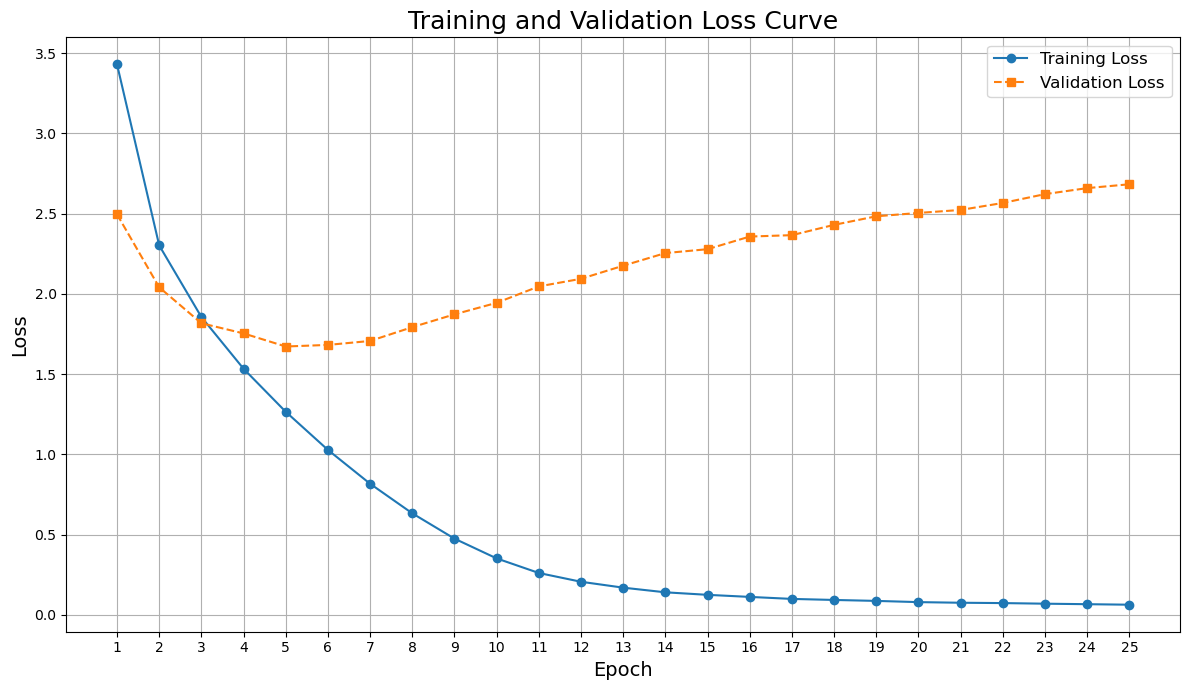

In [1]:
import matplotlib.pyplot as plt

# 提取的训练集和验证集loss
train_loss = [
    3.4299, 2.3018, 1.8557, 1.5334, 1.2653, 1.0277, 0.8169, 0.6326, 0.4749, 0.3517,
    0.2609, 0.2062, 0.1695, 0.1405, 0.1248, 0.1119, 0.0994, 0.0929, 0.0870, 0.0794,
    0.0755, 0.0734, 0.0696, 0.0665, 0.0633
]

val_loss = [
    2.4953, 2.0408, 1.8169, 1.7535, 1.6720, 1.6819, 1.7065, 1.7926, 1.8723, 1.9441,
    2.0464, 2.0938, 2.1754, 2.2541, 2.2783, 2.3570, 2.3657, 2.4299, 2.4833, 2.5041,
    2.5228, 2.5663, 2.6214, 2.6588, 2.6827
]

epochs = range(1, 26)

# 绘制曲线
plt.figure(figsize=(12, 7))
plt.plot(epochs, train_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s', linestyle='--')
plt.title('Training and Validation Loss Curve', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(epochs, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# 保存为高清图片
plt.savefig('loss_curve.png', dpi=300)  # dpi=300 表示高清
plt.show()
